<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_CNN_MNISTshifted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
# shape of the data matrix
data.shape

(20000, 785)

In [4]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# NEW: reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)

(20000,)
(20000, 784)


## Create train/test groups using dataloader

In [5]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Shift the test images by a few pixels

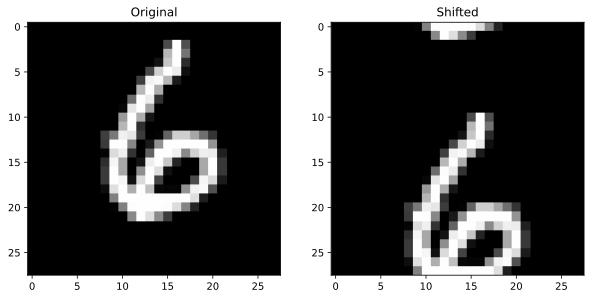

In [8]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0, :]
# tmp = tmp.reshape(28, 28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp, 8, dims=1)

# now show them both
fig, ax = plt.subplots(1,2 , figsize=(10, 6))
ax[0].imshow(np.squeeze(tmp), cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(np.squeeze(tmpS), cmap='gray')
ax[1].set_title('Shifted')

plt.show()

In [11]:
# now repeat for all images in the test set

for i in range(train_loader.dataset.tensors[0].shape[0]):
    
    # get the image
    img = train_loader.dataset.tensors[0][i, :, :]

    # reshape and roll by max. 10 pixels
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img, randroll, dims=1)

    # re-vectorize and put back into the matrix
    train_loader.dataset.tensors[0][i, :, :] = img



In [10]:
# now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):
    
    # get the image
    img = test_loader.dataset.tensors[0][i, :, :]

    # reshape and roll by max. 10 pixels
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img, randroll, dims=1)

    # re-vectorize and put back into the matrix
    test_loader.dataset.tensors[0][i, :, :] = img



## Create the DL model

In [12]:
# # create a class for the model

# def createTheMNISTNet():

#     class mnistNet(nn.Module):
#         def __init__(self):
#             super().__init__()

#             ## input layer
#             self.input = nn.Linear(784, 64)

#             ## hidden layer
#             self.fc1 = nn.Linear(64, 32)
#             self.fc2 = nn.Linear(32, 32)

#             ## output layer
#             self.output = nn.Linear(32, 10)
        
#         # forward pass
#         def forward(self, x):
#             x = F.relu(self.input(x))
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
            
#             return torch.log_softmax(self.output(x), axis=1)

        
#     net = mnistNet()

#     # loss function 
#     lossfun = nn.NLLLoss()

#     # optimizer
#     optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

#     return net, lossfun, optimizer

In [13]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            ### convolution layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            # size: np.floor((28+2*1-5)/1)+1 = 26/2 = 13 (/2 b/c maxpool)

            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            # size : np.floor((13 + 2*1-5)/1) + 1 = 11/2 = 5 (/2 b/c maxpool)


            # compute the number of units in FClayer (number of outputs of conv2)
            expectSize = np.floor((5 + 2 * 0 - 1)/1) + 1 # fc1 layer has no padding or kernel, so
            expectSize = 20 * int(expectSize**2)

            ### fully-connected layer
            self.fc1 = nn.Linear(expectSize, 50)

            ### output layer
            self.out = nn.Linear(50, 10)
            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # forward pass
        def forward(self, x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorize: {x.shape}')

            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x

    # create the model instance
    net = mnistNet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer

In [14]:
# # test the model with one batch
# net, lossfun, optimizer = createTheMNISTNet()

# X, y = iter(train_loader).next()
# yHat = net(X)
# # value s are log-probability of each number (0-9)
# print(yHat.shape)
# # now let's compute the loss
# loss = lossfun(yHat, y)
# print(' ')
# print('Loss: ')
# print(loss)

In [15]:
def function2trainTheModel():

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [16]:
trainAcc, testAcc, losses, net = function2trainTheModel()

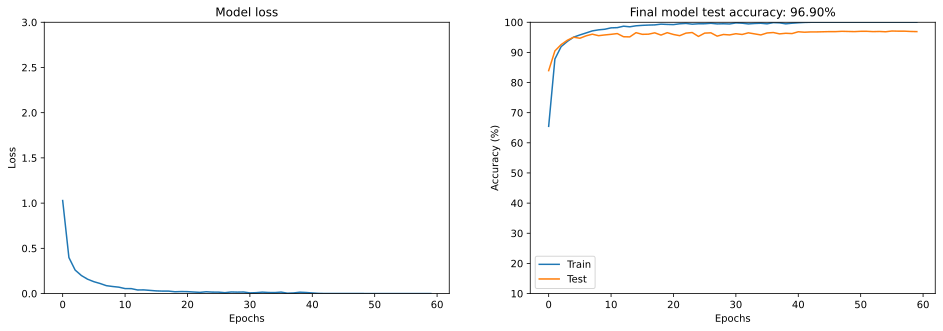

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Inspect the results in more detail

In [18]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

In [19]:
torch.exp(predictions)

tensor([[8.7727e+00, 1.0326e-10, 1.4189e-07,  ..., 4.8401e-14, 1.4259e-02,
         1.7678e-10],
        [2.7543e-05, 4.2260e-09, 1.9792e-09,  ..., 4.4570e-02, 1.0462e-04,
         2.9971e+05],
        [7.9448e-01, 3.5002e-09, 2.4411e+11,  ..., 5.4816e+08, 2.1460e-16,
         1.0138e-02],
        ...,
        [2.2396e-30, 9.6928e-08, 7.0131e+05,  ..., 4.3544e-03, 2.7884e-11,
         9.4199e-09],
        [1.1665e-12, 5.5363e-18, 3.4913e-08,  ..., 7.0452e-06, 1.9317e-11,
         4.3190e+08],
        [1.3206e-21, 1.3147e-26, 1.4597e-10,  ..., 5.6249e-07, 1.8350e-13,
         9.6766e+14]])

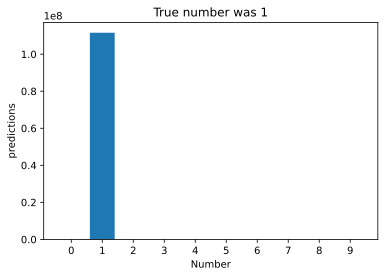

In [20]:
# Evidence for all numbers from one sample
sample2show = 323

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('predictions')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   1    3    4   18   55   80   99  103  109  111  135  151  166  171
  190  192  195  227  233  235  245  247  258  259  265  272  311  346
  367  376  381  408  458  486  518  573  581  602  639  664  744  763
  778  852  862  876  886  915  930  952  975  987 1016 1043 1048 1056
 1070 1089 1092 1094 1102 1114 1120 1149 1202 1257 1290 1314 1364 1373
 1402 1430 1496 1508 1517 1519 1549 1579 1595 1643 1660 1672 1774 1786
 1788 1823 1834 1852 1882 1885 1897 1903 1921 1975 1986]


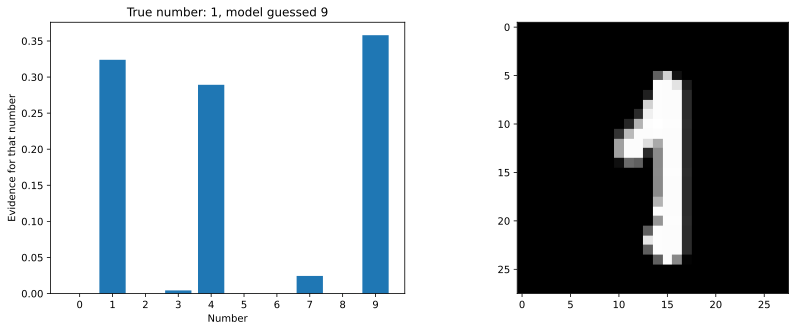

In [ ]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()